In [1]:
!pip install --upgrade tfds-nightly
!pip install --upgrade tensorflow tensorflow-datasets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# EMNIST 데이터셋 로드
ds_builder = tfds.builder("emnist/balanced")
ds_builder.download_and_prepare()
ds_info = ds_builder.info
dataset = ds_builder.as_data_source()

# Define the label mapping
label_mapping = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',  # 숫자
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',  # 대문자
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',  # 대문자
    'U', 'V', 'W', 'X', 'Y', 'Z',                     # 대문자
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't'  # 소문자
]

# 이미지 크기 조정 및 정규화
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # 이미지 크기를 224x224로 조정
    image = tf.image.grayscale_to_rgb(image)    # 그레이스케일 이미지를 RGB로 변환
    image = image / 255.0                       # 정규화
    return image, label

# 데이터 생성 (train, test)
X = []
y = []
for example in dataset['train']:
    X.append(example['image'])
    y.append(example['label'])

X_test = []
y_test = []
for example in dataset['test']:
    X_test.append(example['image'])
    y_test.append(example['label'])

X = np.array(X)
y = np.array(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

# dataset 분할 (test:validation = 5:1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/6, random_state=42)


In [9]:
# Convert integer labels to character labels
#def convert_labels_to_characters(labels, label_mapping):
#    return np.array([label_mapping[label] for label in labels])

# 원-핫 인코딩
y_train_enc = tf.keras.utils.to_categorical(y_train, num_classes=len(label_mapping))
y_valid_enc = tf.keras.utils.to_categorical(y_valid, num_classes=len(label_mapping))
y_test_enc = tf.keras.utils.to_categorical(y_test, num_classes=len(label_mapping))

# 데이터셋 구성 및 배치 설정
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc)).map(preprocess).shuffle(1000).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid_enc)).map(preprocess).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc)).map(preprocess).batch(32)

In [10]:
# 데이터셋 확인
print(ds_info)
print(dataset)
print(train_dataset)
print(valid_dataset)
print(test_dataset)
print("훈련 데이터셋 크기:", len(X_train))
print("검증 데이터셋 크기:", len(X_valid))
print("테스트 데이터셋 크기:", len(X_test))

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/balanced/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Balanced
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='/root/tensorflow_datasets/emnist/balanced/3.1.0',
    file_format=array_record,
    download_size=535.73 MiB,
    dataset_size=56.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=47),
    }),
    supervis

In [11]:
import tensorflow as tf

class BottleneckResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.strides = strides

        # 컨볼루션 및 배치 정규화 레이어
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding="same", use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2D(filters * 4, kernel_size=1, padding="same", use_bias=False)
        self.bn3 = tf.keras.layers.BatchNormalization()

        # 스트라이드가 1보다 클 때만 shortcut을 위한 레이어 추가
        if strides != 1:
            self.shortcut = tf.keras.Sequential([
                tf.keras.layers.Conv2D(filters * 4, kernel_size=1, strides=strides, padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()
            ])
        else:
            self.shortcut = None

    def call(self, inputs, training=False):
        # 메인 경로
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.keras.layers.Activation("relu")(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.keras.layers.Activation("relu")(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)

        # shortcut 경로
        if self.shortcut is not None:
            shortcut = self.shortcut(inputs)
        else:
            shortcut = inputs

        # Residual을 더하고 활성화 함수 적용
        x = tf.keras.layers.Add()([x, shortcut])
        return tf.keras.layers.Activation("relu")(x)

    def build(self, input_shape):
        # 'build' 메소드에서는 추가적인 초기화 작업을 할 수 있지만 현재는 필요 없음
        super().build(input_shape)

# 이제 모델을 재정의하고 모든 것이 잘 작동하는지 확인합니다.
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

# 각각의 convolutional block 설정
for filters, blocks in zip([64, 128, 256, 512], [3, 4, 6, 3]):
    for i in range(blocks):
        strides = 2 if i == 0 else 1
        x = BottleneckResidualUnit(filters, strides=strides)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(label_mapping), activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 112, 112, 64)        │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_106              │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_146 (Activation)          │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_residual_unit_32          │ (None, 28, 28, 256)         │          76,288 │
│ (BottleneckResidualUnit)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_residual_unit_33          │ (None, 28, 28, 256)         │          71,168 │
│ (BottleneckResidualUnit)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_residual_unit_34          │ (None, 28, 28, 256)         │          71,168 │
│ (BottleneckResidualUnit)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_residual_unit_35          │ (None, 14, 14, 512)         │         381,952 │
│ (BottleneckResidualUnit)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_residual_unit_36          │ (None, 14, 14, 512)         │         281,600 │
│ (BottleneckResidualUnit)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_residual_unit_37          │ (None, 14, 14, 512)         │         281,600 │
│ (BottleneckResidualUnit)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_residual_unit_38          │ (None, 14, 14, 512)         │         281,600 │
│ (BottleneckResidualUnit)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_residual_unit_39          │ (None, 7, 7, 1024)          │       1,517,568 │
│ (BottleneckResidualUnit)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_residual_unit_40          │ (None, 7, 7, 1024)          │       1,120,256 │
│ (BottleneckResidualUnit)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_residual_unit_41          │ (None, 7, 7, 1024)          │       1,120,256 │
│ (BottleneckResidualUnit)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_residual_unit_42          │ (None, 7, 7, 1024)          │       1,120,2

 Total params: 23,657,455 (90.25 MB)

 Trainable params: 23,604,335 (90.04 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
# 모델 훈련
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)

# 모델 평가
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.3f}")

Epoch 1/10
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 455s 138ms/step - accuracy: 0.6840 - loss: 1.1550 - val_accuracy: 0.8223 - val_loss: 0.5395
Epoch 2/10
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 371s 126ms/step - accuracy: 0.8482 - loss: 0.4310 - val_accuracy: 0.8386 - val_loss: 0.4559
Epoch 3/10
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 379s 125ms/step - accuracy: 0.8687 - loss: 0.3655 - val_accuracy: 0.8710 - val_loss: 0.3621
Epoch 4/10
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 384s 125ms/step - accuracy: 0.8816 - loss: 0.3206 - val_accuracy: 0.8786 - val_loss: 0.3459
Epoch 5/10
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 380s 125ms/step - accuracy: 0.8923 - loss: 0.2858 - val_accuracy: 0.8793 - val_loss: 0.3281
Epoch 6/10
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 382s 125ms/step - accuracy: 0.8992 - loss: 0.2592 - val_accuracy: 0.8839 - val_loss: 0.3308
Epoch 7/10
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 370s 125ms/step - accuracy: 0.9084 - loss: 0.2313 - val_accuracy: 0.8903 - val_loss: 0.3143
Epoch 8/10
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 393s 133ms/step - ac

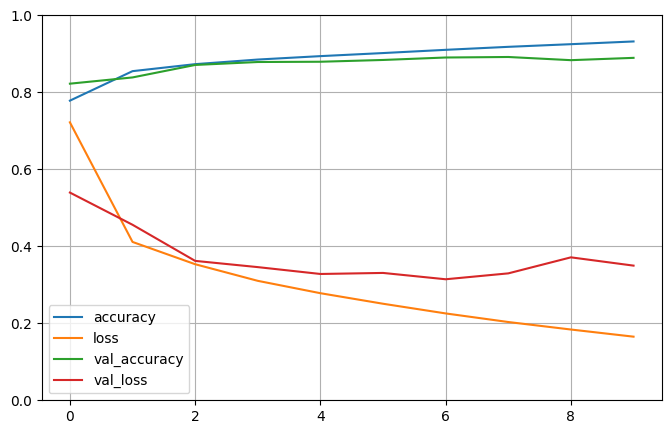

In [15]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()